# Importing Libraries

In [15]:
import plotly.offline as pox
import plotly.graph_objs as go
import numpy as np
import talib as tl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import talib as ta
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report
import alpaca_trade_api as tradeapi
from alpaca_trade_api import TimeFrame, TimeFrameUnit
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from matplotlib.pyplot import figure
from statsmodels.tsa.stattools import adfuller
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier

# Importing Stock Data

In [16]:
# df=pd.read_csv('FB.csv')
# d = df[ df['Volume'] == 0 ]
# df = df.drop(d.index,axis=0)
# df=df.set_index(pd.DatetimeIndex(df['Gmt time'].values))
# df['Gmt time']=pd.to_datetime(df['Gmt time'])
# df=df.sort_values("Gmt time",ascending=True)
# df.drop('Gmt time', inplace=True, axis=1)
SEC_KEY = '7mi6lnaTynfrzxfDYyYUarBpUJ35sSgVEVIj6RZG'
PUB_KEY ='PKDL8E9SBYH9GYYXXZNL'
BASE_URL ='https://paper-api.alpaca.markets'
symb = "TSLA"
api = tradeapi.REST(key_id= PUB_KEY, secret_key=SEC_KEY, base_url=BASE_URL) # For real trading, don't enter a base_url
df = api.get_barset(symb, TimeFrame(15, TimeFrameUnit.Minute), limit=1000).df  # Get one bar object for each of the past 5 minutes
df=df[symb]
# df.drop(df.tail(16).index,inplace=True)
next=df.copy()
next.tail()

,open,high,low,close,volume
time,,,,,
2022-02-18 14:45:00-05:00,855.76,858.63,852.27,858.20,15497
2022-02-18 15:00:00-05:00,859.09,862.26,856.54,858.13,13975
2022-02-18 15:15:00-05:00,857.79,859.13,854.83,856.52,28240
2022-02-18 15:30:00-05:00,855.18,857.90,850.72,856.27,19926
2022-02-18 15:45:00-05:00,857.72,857.99,853.06,856.97,46035


In [17]:
# df['close']=df['Close']
# df['high']=df['High']
# df['low']=df['Low']
# df['open']=df['Open']
# df['volume']=df['Volume']

# Feature Engineering

In [18]:
df['future_returns'] = df['close'].pct_change().shift(-1)
signal=[]
for i in range(len(df)):
            if (df['future_returns'][i]  > 0):
                signal.append(1)
            elif (df['future_returns'][i] < 0):
                signal.append(2)
            else:
                signal.append(3)

df['signal']=signal
df['rsi'] = ta.RSI(df['close'].values, timeperiod=int(14))
df['adx'] = ta.ADX(df['high'].values, df['low'].values,df['open'].values, timeperiod=int(50))
df['NATR'] = ta.NATR(df['high'], df['low'], df["close"], timeperiod=50)
df['pct_change5'] = df['close'].pct_change(5)
df['pct_change'] = df['close'].pct_change()
df['sma'] = ta.SMA(df['close'],timeperiod=30)
df['corr'] = df['close'].rolling(window=int(6.5*4)).corr(df['sma'])
df['Open-Close']=(df["open"]-df['close']).shift(-1)
df['Close-High']=(df["close"]-df['high']).shift(-1)
df['Close-Low']=(df["close"]-df['low']).shift(-1)

df.dropna(inplace=True)
y = df[['signal']].copy()
X = df[[ 'rsi','adx', 'corr','volume','Open-Close','Close-Low']].copy()

# Correlation Check

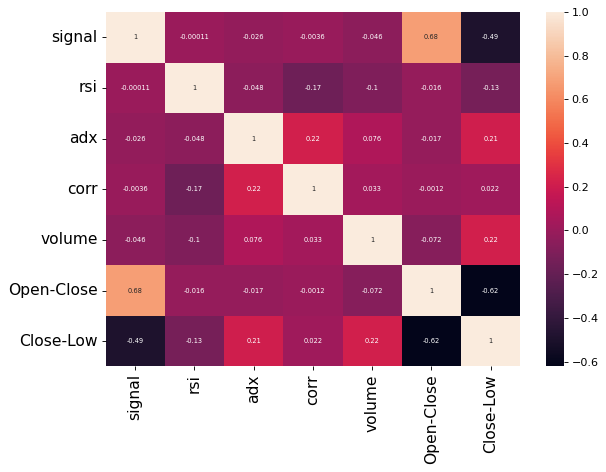

In [19]:
z=df[['signal', 'rsi','adx', 'corr','volume','Open-Close','Close-Low']].copy()
corr = z.corr()
figure(figsize=(8, 6), dpi=80)
sns.heatmap(corr, annot=True, annot_kws = {"size": 6})
plt.yticks(rotation=0, size = 14); 
plt.xticks(rotation=90, size = 14)  # fix ticklabel directions and size
plt.tight_layout()  # fits plot area to the plot, "tightly"
plt.show()  # show the plot

In [20]:
def get_pair_above_threshold(X, threshold):
    """Function to return the pairs with correlation above threshold.
    """
    # Calculate the correlation matrix
    correl = X.corr()

    # Unstack the matrix
    correl = correl.abs().unstack()

    # Recurring & redundant pair
    pairs_to_drop = set()
    cols = X.corr().columns
   
    for i in range(0, X.corr().shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))

    # Drop the recurring & redundant pair
    correl = correl.drop(labels=pairs_to_drop).sort_values(ascending=False)

    return correl[correl > threshold].index


print(get_pair_above_threshold(X, 0.7))


MultiIndex([], )


# Stationary Check

In [21]:
def stationary(series):
    """Function to check if the series is stationary or not.
    """
    result = adfuller(series)
    if(result[1] < 0.05):
        return 'stationary'
    else:
        return 'not stationary'
# Check for stationarity
for col in X.columns:
    if stationary(df[col]) == 'not stationary':
        print('%s is not stationary. Dropping it.' % col)
        X.drop(columns=[col], axis=1, inplace=True)
    else:
        print('%s is stationary.' % col)
        


rsi is stationary.
adx is stationary.
corr is stationary.
volume is stationary.
Open-Close is stationary.
Close-Low is stationary.


# Splitting and Training Model

In [22]:
split_percentage = 0.8
split = int(split_percentage*len(df))


# Train data set
X_train = X[:split]
y_train = y[:split]
X_test =  X[split:]
y_test =  y[split:]
        
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.fit_transform(X_test)
# model=SVC()
# model1 = KNeighborsClassifier(n_neighbors=50)
# model2 = LogisticRegression()
# model3=DecisionTreeClassifier()
# model=SVC()
# model=VotingClassifier([('knn',model1),('lr',model2),('ds',model3),('svm',model4)])
# model=AdaBoostClassifier(base_estimator=model3)
model = RandomForestClassifier(n_estimators=100,random_state=30)
model.fit(X_train, y_train['signal'])
y_pred = model.predict(X_test)
Accuracy =accuracy_score(y_test, y_pred)
print(Accuracy)

0.8944444444444445


# confusion Matrix

In [23]:
# Classification report
classification_report_data = classification_report(y_test, y_pred)
# Print the classification report
print(classification_report_data)

              precision    recall  f1-score   support

           1       0.84      0.95      0.89        80
           2       0.96      0.85      0.90       100

    accuracy                           0.89       180
   macro avg       0.90      0.90      0.89       180
weighted avg       0.90      0.89      0.89       180



# Making Latest Prediciton

In [24]:
Prediction=model.predict(X)[-1]
if Prediction==1:
    print('Buy')
elif Prediction==2:
    print('Sell')
else:
    print('Hold')
print(Prediction)

C:\Users\Azaz\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:438: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names



Sell
2


In [25]:
split_percentage = 0.8
split = int(split_percentage*len(df))
temp=pd.DataFrame()
temp['close'] = df.close.iloc[split:]
temp['signal']=np.array(y_pred)
temp.tail()

,close,signal
time,,
2022-02-18 14:30:00-05:00,855.77,1
2022-02-18 14:45:00-05:00,858.20,2
2022-02-18 15:00:00-05:00,858.13,2
2022-02-18 15:15:00-05:00,856.52,1
2022-02-18 15:30:00-05:00,856.27,2


In [26]:
# Variable Required for decision making
buy=[]
sell=[]
profit=[]
Close_profit=[]
Stop_loss=[]
Close_order_buy=[]
Close_order_sell=[]
position_Buy=None
position_Sell=None
profit=0.4
lose=0.4

# Decision Making Process

In [27]:
for i in range(len(temp)):
   #####################################################################################################
    if position_Buy!="Buy"  and position_Sell!="Sell" and Accuracy >0.50 and temp['signal'][i]== 1 :                          #Buy Position
                    buy.append(temp['close'][i])
                    sell.append(np.nan)
                    Close_profit.append(np.nan)
                    Stop_loss.append(np.nan)
                    Close_order_buy.append(temp['close'][i])
                    position_Buy="Buy"
    #############################################################################################
    elif  position_Sell!="Sell"  and position_Buy!="Buy" and Accuracy >0.50 and temp['signal'][i]== 2   :                     #Sell Position        
                sell.append(temp['close'][i])              
                buy.append(np.nan)
                Close_profit.append(np.nan)
                Stop_loss.append(np.nan)
                Close_order_sell.append(temp['close'][i])
                position_Sell="Sell"
        
    #################################################################################################
    elif position_Sell=="Sell" :                                               #Closing Order  After  Buying a trade(Profit)
        if ((Close_order_sell[-1]+lose) <= temp['close'][i]):                   #Take Profit Condition
            Close_profit.append(np.nan)                                        #append to take profit
            Stop_loss.append(temp['close'][i])
            buy.append(np.nan)
            sell.append(np.nan)
            position_Sell=None
        elif ((Close_order_sell[-1]-(profit)) >= temp['close'][i]):                   #Stop Loss Condition
            Close_profit.append(temp['close'][i])
            Stop_loss.append(np.nan)                                                #Appending to stop loss
            buy.append(np.nan)
            sell.append(np.nan)
            position_Sell=None
        else:
            Close_profit.append(np.nan)
            Stop_loss.append(np.nan)
            buy.append(np.nan)
            sell.append(np.nan)
    ########################################################################################################
    elif position_Buy=="Buy" :                                               #Closing Order  After  Buying a trade(Profit)
        if ((Close_order_buy[-1]+profit) <= temp['close'][i]):                  #Take Profit Condition
            Close_profit.append(temp['close'][i])                          #append to take profit
            Stop_loss.append(np.nan)
            buy.append(np.nan)
            sell.append(np.nan)
            position_Buy=None
           
        elif ((Close_order_buy[-1]-lose) >= temp['close'][i]):                   #Stop Loss Condition
            Close_profit.append(np.nan)
            Stop_loss.append(temp['close'][i])                                  #Appending to stop loss
            buy.append(np.nan)
            sell.append(np.nan)
            position_Buy=None
     
        else:
            Close_profit.append(np.nan)
            Stop_loss.append(np.nan)
            buy.append(np.nan)
            sell.append(np.nan)
#################################################################
    else:
            buy.append(np.nan)
            sell.append(np.nan)
            Stop_loss.append(np.nan)
            Close_profit.append(np.nan)
temp['buy']=buy
temp['sell']=sell
temp['Close_profit']=Close_profit
temp['Stop_loss']=Stop_loss
print((temp[temp['buy']!=np.nan]).count())
print(f"Profitibily { temp['Close_profit'].count()/(temp['Close_profit'].count()+temp['Stop_loss'].count())}")

close           180
signal          180
buy              41
sell             43
Close_profit     72
Stop_loss        11
dtype: int64
Profitibily 0.8674698795180723


# Plotting

In [14]:
# trace1=go.Candlestick(
# x=df.index,
# low=df['low'],
# close=df['close'],
# open=df['open'],
# high=df['high'],
# increasing_line_color='green',
# decreasing_line_color='red',
# name='USD/EUR',
# )
trace1=go.Scatter(
    y=temp.close,
    mode='lines',
    name='Close_price'
)

trace4=go.Scatter(
   
    y=temp['buy'],
    mode='markers',
    marker=dict(size=13,color='#00FF00',symbol='triangle-up' ),
    name='buy'
    )
trace5=go.Scatter(
    
    y=temp.sell,
    mode='markers',
    marker=dict(size=13,color='#FF0000',symbol='triangle-down'),
    name='sell')
trace6=go.Scatter(
    
    y=temp.Close_profit,
    mode='markers',
    marker=dict(size=13,color='#00FF00',symbol='cross'),
    name='Profit')
trace7=go.Scatter(
    
    y=temp.Stop_loss,
    mode='markers',
    marker=dict(size=13,color='#FF0000',symbol='cross'),
    name='Loss')

data=[trace1,trace4,trace5,trace6,trace7]
layout=go.Layout(
    title=symb,
    yaxis=dict(title='Assest value'),
    xaxis=dict(title='Time And date'))
figure=go.Figure(data=data,layout=layout)
figure.update_layout(xaxis_rangeslider_visible=False)
pox.plot(figure)

'temp-plot.html'